In [1]:
import numpy as np
import matplotlib.pyplot as plt
import asdf
import symlib
import sys
sys.path.append('/sdf/home/j/jaymarie/software/gravitree/python')
import gravitree
import astropy.units as u
from tqdm import tqdm

# from plot import setFonts
# setFonts()

sim_dir = "/fs/ddn/sdf/group/kipac/g/cosmo/ki21/phil1/simulations/ZoomIns/SymphonyMilkyWay/Halo023"

from mwgcs import Simulation, GCSystem, MassProfile, NFW, Einasto, sampleDwarfGCMF, getMassLossRate, mdot_gg23

Gravitree path added to sys.path.


# direct N-body

In [2]:
import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics.nbody import DirectNBody
from gala.units import galactic, UnitSystem

In [3]:
import numpy as np
import gala.potential as gp
from gala.units import galactic

dm     = gp.NFWPotential(m=1e12, r_s=25., units=galactic)
baryon = gp.PlummerPotential(m=4e10, b=1.6, units=galactic)
pot    = dm + baryon

def getTidalStrength(q):
    hess = pot.hessian(q)
    tidal_tensor = hess - np.multiply((1/3)*np.trace(hess, axis1=0, axis2=1), np.tile(np.identity(3), (hess.shape[2], 1, 1)).T)
    eigs = np.linalg.eigvals(tidal_tensor.T)
    lam = np.max(np.abs(eigs), axis=1)
    return lam

In [4]:
# palomar 5 orbital parameters
r_apo = 15.5
r_peri = 6.5
ecc = 0.41

w0 = gd.PhaseSpacePosition(pos=[r_apo, 0., 0.] * u.kpc, vel=[0., 150., 0.] * u.km/u.s)
particle_pot = [None]
nbody = DirectNBody(w0, particle_pot, external_potential=pot)

orbits = nbody.integrate_orbit(dt=1e-2*u.Myr, t1=0, t2=1*u.Gyr)

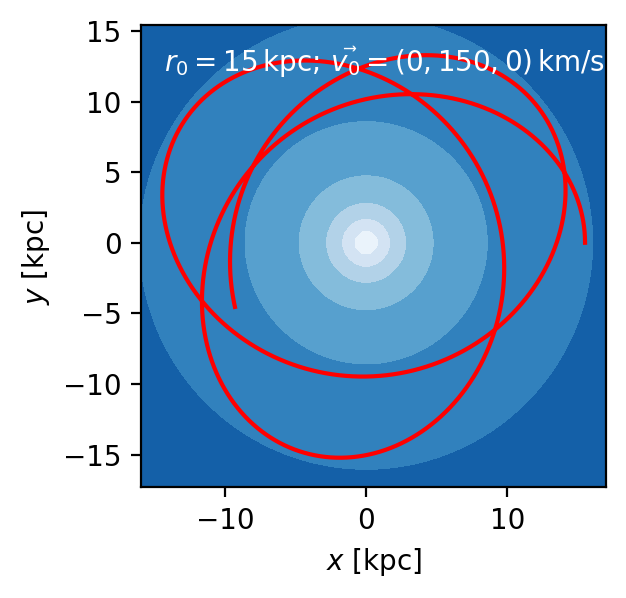

In [5]:
fig, ax = plt.subplots(dpi=200, figsize=(3,3))
# orbit and potential
_ = orbits[:, 0].plot(['x', 'y'], axes=[ax], color='red') 
x = np.linspace(-25, 25, 100)
y = np.linspace(-25, 25, 100)
pot.plot_contours(grid=(x, y, 0.), ax=ax)
ax.text(.05, .9, r'$r_0 = 15 \mathrm{\, kpc}; \, \vec{v_0} = (0, 150, 0) \mathrm{\, km / s}$', color='white', transform=ax.transAxes)
plt.show()

In [ ]:
orbit averaged mass loss

# mass loss rates

In [6]:
lams = getTidalStrength(orbits[:, 0].xyz)

In [7]:
dt = (orbits[:, 0].t[1:] - orbits[:, 0].t[:-1]).to(u.Gyr)[0].value

In [8]:
mass = np.zeros(len(orbits[:, 0].t))
gg_mass = np.zeros(len(orbits[:, 0].t))
initial_mass = 3.5e4
mass[0] = initial_mass
gg_mass[0] = initial_mass

for i in tqdm(range(len(orbits[:, 0].t)-1)):
    mass[i+1] = mass[i] + getMassLossRate(mass[i], lams[i]).to(1/u.Gyr).value * dt
    gg_mass[i+1] = gg_mass[i] + mdot_gg23(gg_mass[i], lams[i], initial_mass).to(1/u.Gyr).value * dt

100%|██████████| 100000/100000 [00:36<00:00, 2776.63it/s]


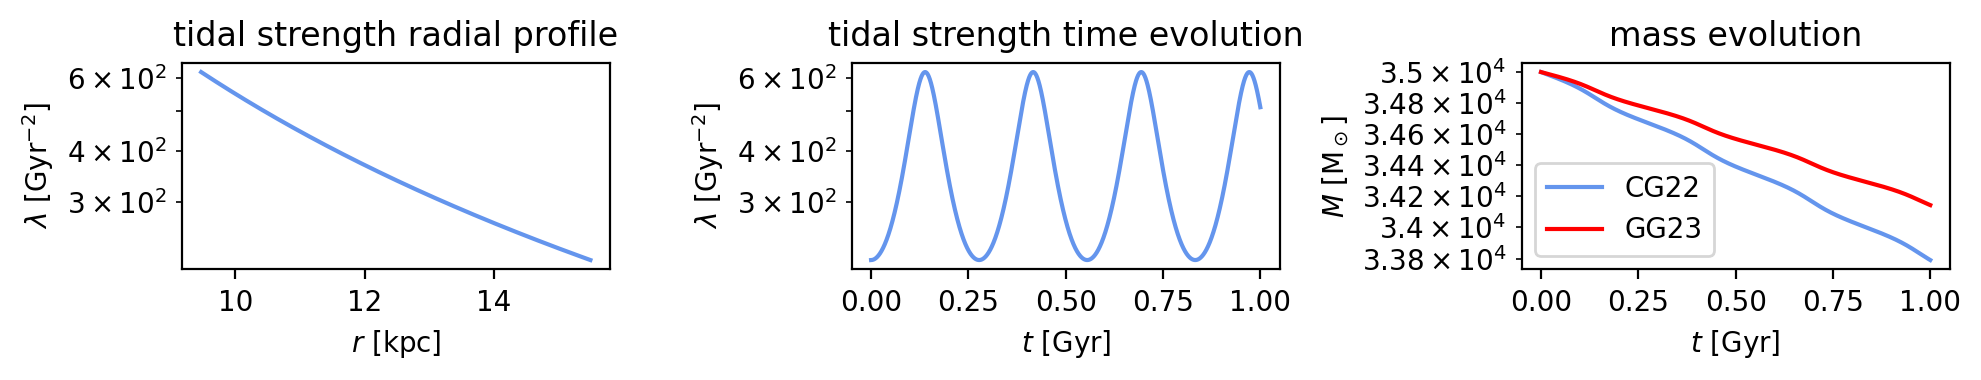

In [9]:
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(10,2))


# tidal strength over radius
_r = np.sqrt(np.sum(orbits[:, 0].xyz**2, axis=0))
sorted_idx = np.argsort(_r)
ax[0].plot(_r[sorted_idx], lams[sorted_idx].to(u.Gyr**(-2)), c='cornflowerblue', label='CG22')
ax[0].set_yscale('log')
ax[0].set_xlabel(r'$r$ [kpc]')
ax[0].set_ylabel(r'$\lambda$ [$\mathrm{Gyr^{-2}}$]')
ax[0].set_title('tidal strength radial profile')

# tidal strength over time
_t = orbits[:, 0].t.to(u.Gyr)
sorted_idx = np.argsort(_t)
ax[1].plot(_t[sorted_idx], lams[sorted_idx].to(u.Gyr**(-2)), c='cornflowerblue', label='CG22')
ax[1].set_yscale('log')
ax[1].set_xlabel(r'$t$ [Gyr]')
ax[1].set_ylabel(r'$\lambda$ [$\mathrm{Gyr^{-2}}$]')
ax[1].set_title('tidal strength time evolution')

# mass loss
_t = orbits[:, 0].t.to(u.Gyr)
sorted_idx = np.argsort(_t)
ax[2].plot(_t[sorted_idx], mass[sorted_idx], c='cornflowerblue', label='CG22')
ax[2].plot(_t[sorted_idx], gg_mass[sorted_idx], c='red', label='GG23')
ax[2].set_yscale('log')
ax[2].set_xlabel(r'$t$ [Gyr]')
ax[2].set_ylabel(r'$M$ [$\mathrm{M_\odot}$]')
ax[2].set_title('mass evolution')

ax[2].legend()

fig.tight_layout()
plt.show()

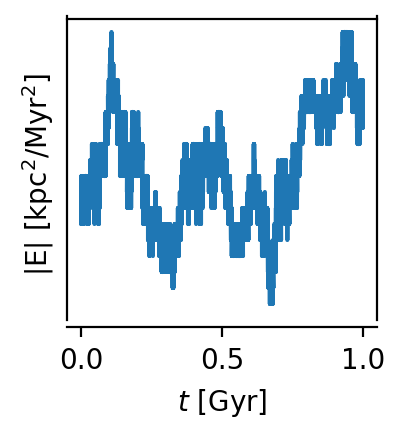

In [10]:
fig, ax = plt.subplots(dpi=200, figsize=(2,2))
_t = orbits[:, 0].t.to(u.Gyr)
sorted_idx = np.argsort(_t)
ax.plot(_t[sorted_idx], np.abs(orbits[:, 0].energy()[sorted_idx]))
ax.set_xlabel(r'$t$ [Gyr]')
ax.set_ylabel(r'|E| $[\mathrm{kpc^2 / Myr^2}]$')
ax.set_yscale('log')
plt.show()

# coarse mass loss

In [11]:
.01 * 1000

10.0

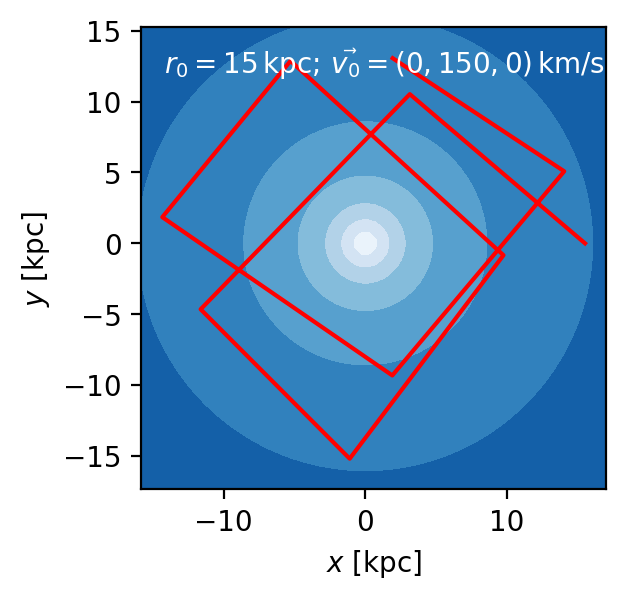

In [12]:
# w0 = gd.PhaseSpacePosition(pos=[200., 0., 0.] * u.kpc, vel=[0., 2000., 0.] * u.km/u.s)
particle_pot = [None]
nbody = DirectNBody(w0, particle_pot, external_potential=pot)
orbits = nbody.integrate_orbit(dt=100*u.Myr, t1=0, t2=1*u.Gyr)

fig, ax = plt.subplots(dpi=200, figsize=(3,3))
# orbit and potential
_ = orbits[:, 0].plot(['x', 'y'], axes=[ax], color='red') 
x = np.linspace(-25, 25, 100)
y = np.linspace(-25, 25, 100)
pot.plot_contours(grid=(x, y, 0.), ax=ax)
ax.text(.05, .9, r'$r_0 = 15 \mathrm{\, kpc}; \, \vec{v_0} = (0, 150, 0) \mathrm{\, km / s}$', color='white', transform=ax.transAxes)
plt.show()

100%|██████████| 9/9 [00:00<00:00, 2130.17it/s]


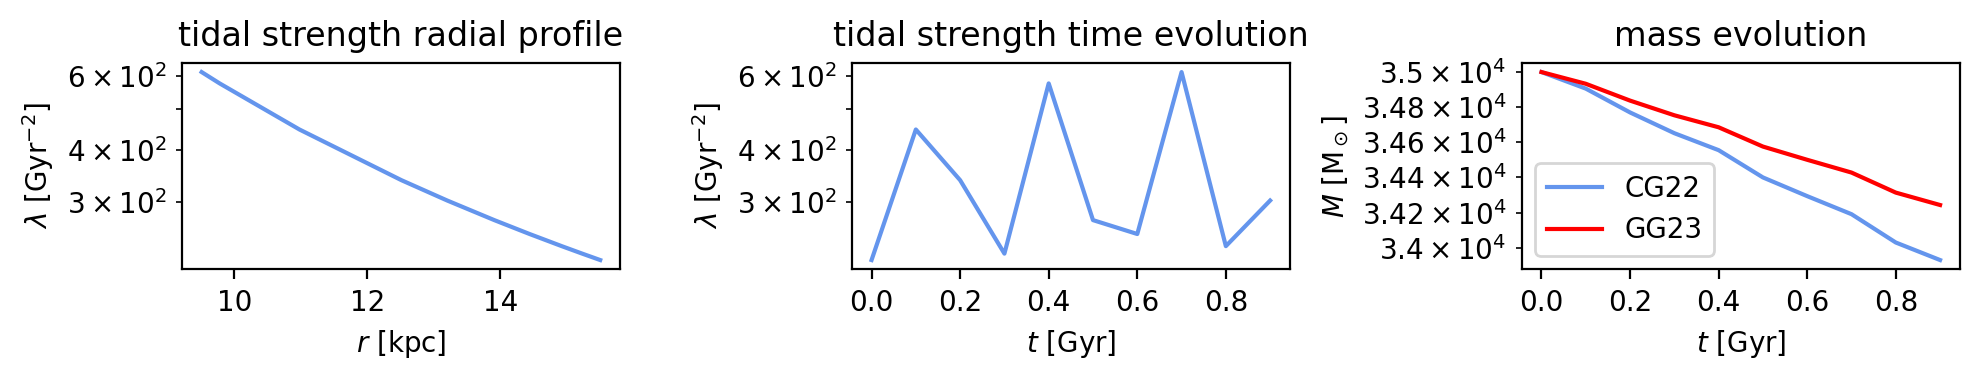

In [13]:
lams = getTidalStrength(orbits[:, 0].xyz)
dt = (orbits[:, 0].t[1:] - orbits[:, 0].t[:-1]).to(u.Gyr)[0].value
mass = np.zeros(len(orbits[:, 0].t))
gg_mass = np.zeros(len(orbits[:, 0].t))
initial_mass = 3.5e4
mass[0] = initial_mass
gg_mass[0] = initial_mass

for i in tqdm(range(len(orbits[:, 0].t)-1)):
    mass[i+1] = mass[i] + getMassLossRate(mass[i], lams[i]).to(1/u.Gyr).value * dt
    gg_mass[i+1] = gg_mass[i] + mdot_gg23(gg_mass[i], lams[i], initial_mass).to(1/u.Gyr).value * dt
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(10,2))


# tidal strength over radius
_r = np.sqrt(np.sum(orbits[:, 0].xyz**2, axis=0))
sorted_idx = np.argsort(_r)
ax[0].plot(_r[sorted_idx], lams[sorted_idx].to(u.Gyr**(-2)), c='cornflowerblue', label='CG22')
ax[0].set_yscale('log')
ax[0].set_xlabel(r'$r$ [kpc]')
ax[0].set_ylabel(r'$\lambda$ [$\mathrm{Gyr^{-2}}$]')
ax[0].set_title('tidal strength radial profile')

# tidal strength over time
_t = orbits[:, 0].t.to(u.Gyr)
sorted_idx = np.argsort(_t)
ax[1].plot(_t[sorted_idx], lams[sorted_idx].to(u.Gyr**(-2)), c='cornflowerblue', label='CG22')
ax[1].set_yscale('log')
ax[1].set_xlabel(r'$t$ [Gyr]')
ax[1].set_ylabel(r'$\lambda$ [$\mathrm{Gyr^{-2}}$]')
ax[1].set_title('tidal strength time evolution')

# mass loss
_t = orbits[:, 0].t.to(u.Gyr)
sorted_idx = np.argsort(_t)
ax[2].plot(_t[sorted_idx], mass[sorted_idx], c='cornflowerblue', label='CG22')
ax[2].plot(_t[sorted_idx], gg_mass[sorted_idx], c='red', label='GG23')
ax[2].set_yscale('log')
ax[2].set_xlabel(r'$t$ [Gyr]')
ax[2].set_ylabel(r'$M$ [$\mathrm{M_\odot}$]')
ax[2].set_title('mass evolution')

ax[2].legend()

fig.tight_layout()
plt.show()

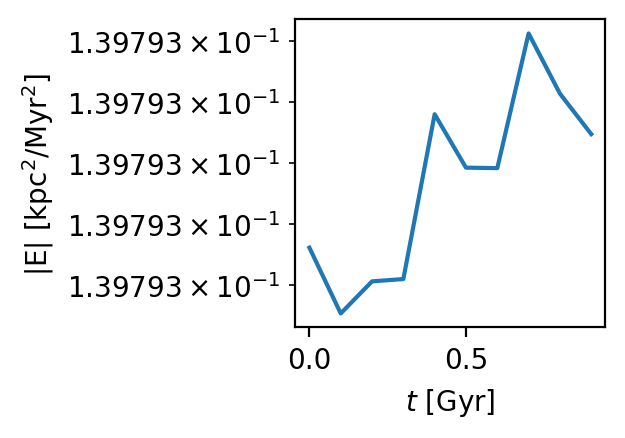

In [14]:
fig, ax = plt.subplots(dpi=200, figsize=(2,2))
_t = orbits[:, 0].t.to(u.Gyr)
sorted_idx = np.argsort(_t)
ax.plot(_t[sorted_idx], np.abs(orbits[:, 0].energy()[sorted_idx]))
ax.set_xlabel(r'$t$ [Gyr]')
ax.set_ylabel(r'|E| $[\mathrm{kpc^2 / Myr^2}]$')
ax.set_yscale('log')
plt.show()